### Test - Synthetic Diagnostic + Interferometry

</b> Author:   </b>  Louis Evans     </br>
</b> Reviewer: </b>  Stefano Merlini

### Import relevant files:

In [1]:
import sys
#add path
sys.path.insert(0, '../../../synthPy/')   # import path/to/synthpy
import numpy as np
import matplotlib.pyplot as plt
import vtk
from vtk.util import numpy_support as vtk_np
import matplotlib.pyplot as plt

import solvers.full_solver as s

To use the ray tracer, first create a 'domain', load the domain with an electron distribution, calculate electron gradients, initialise a beam, and solve!
\
\
The output can either be plotted, or passed further through ray optics for synthetic diagnostics

In [12]:
# define some extent, the domain should be distributed as +extent to -extent, does not need to be cubic
extent_x = 5e-3
extent_y = 5e-3
extent_z = 10e-5
n_cells  = 1000

x = np.linspace(-extent_x, extent_x, n_cells)
y = np.linspace(-extent_y, extent_y, n_cells)
z = np.linspace(-extent_z, extent_z, n_cells)

probing_extent = extent_z
probing_direction = 'z'

domain = s.ScalarDomain(x = x, y = y, z = z, extent= probing_extent, probing_direction = probing_direction)     # create domain

Load some domain distribution

In [13]:
# load some external pvti
# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)
# or load a test distribution

domain.test_exponential_cos()

Solve gradients, initialise beam, and solve

In [14]:
wl = 1064e-9 #define laser wavelength

# initialise beam

Np = 10000    # number of photons
divergence = 5e-5   # realistic divergence value
beam_size = extent_x    # beam radius
ne_extent = probing_extent  # so the beam knows where to initialise initial positions
beam_type = 'circular'

initial_rays = s.init_beam(Np = Np, beam_size = beam_size, divergence = divergence, ne_extent = ne_extent, beam_type = beam_type, probing_direction = probing_direction)

# solve ray trace
domain.calc_dndr(wl)
final_rays = domain.solve(initial_rays)

Ray trace completed in:	 1.1818842887878418 s


Pass through ray optics: For Shadowgaphy, Schlieren, or Refractometry:

In [15]:
import solvers.rtm_solver as rtm

#in the diagnostic initialisation, details on the lens configurations, and detector dimensions can be specified
refractometer = rtm.Refractometry(final_rays)
refractometer.incoherent_solve()
refractometer.histogram(bin_scale = 1, clear_mem = True)

sh=rtm.Shadowgraphy(final_rays)
sh.single_lens_solve()
sh.histogram(bin_scale = 1, clear_mem=True)

sh=rtm.Schlieren(final_rays)
sh.DF_solve()
sh.histogram(bin_scale = 1, clear_mem=True)

#information accessed by .H(istogram) , e.g plt.imshow(refractometer.H)

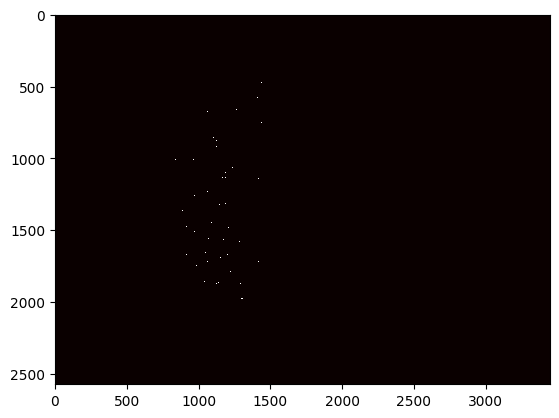

In [19]:
plt.imshow(sh.H, cmap='hot', interpolation='nearest', clim = (0.5, 1))

Synthetic Interferometry - This requires some extra steps in the ray tracing to include information on the phase and electric field values

In [25]:
extent_x = 5e-3 # m
extent_y = 5e-3
extent_z = 10e-3

n_cells = 100

x = np.linspace(-extent_x, extent_x, n_cells)
y = np.linspace(-extent_y, extent_y, n_cells)
z = np.linspace(-extent_z, extent_z, n_cells)

probing_extent = extent_z
probing_direction = 'z'

domain = s.ScalarDomain(x = x, y = y, z = z, extent= probing_extent, probing_direction = probing_direction, phaseshift = True) #specify phaseshift TRUE

# load some external pvti


# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)

# or load a test distribution

domain.test_exponential_cos()

wl = 1064e-9 #define laser wavelength

# initialise beam

Np = 100000 #number of photons
divergence = 5e-5 #realistic divergence value
beam_size = extent_x #beam radius
ne_extent = probing_extent #so the beam knows where to initialise initial positions
beam_type = 'circular'


initial_rays = s.init_beam(Np = Np, beam_size = beam_size, divergence = divergence, ne_extent = ne_extent, beam_type = beam_type, probing_direction = probing_direction)

# solve ray trace

domain.calc_dndr(wl)

final_rays, E = domain.solve(initial_rays, return_E = True)

n_fringes = 10
deg = 10 #adjust number of fringes and tilt in degrees from the vertical exis
final_E = s.interfere_ref_beam(final_rays, E, n_fringes, deg)

pattern= rtm.Interferometry(final_rays, E = final_E)
pattern.two_lens_solve(wl = wl)
pattern.interferogram(bin_scale = 1, clear_mem=True) #use interferogram instead of histogram

#get interferogram histogram with sh.H


Ray trace completed in:	 23.97766351699829 s


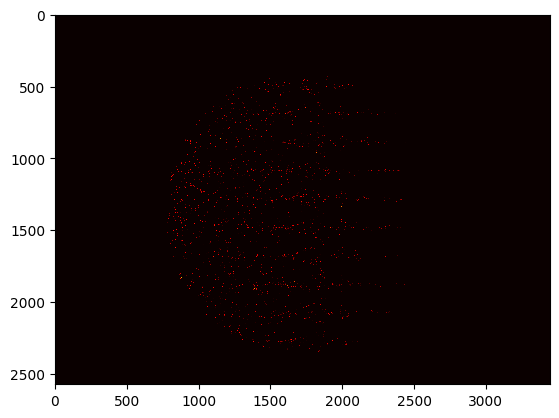

In [26]:
plt.imshow(pattern.H, cmap='hot', interpolation='nearest')